## Import dependencies all you need

In [24]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import csv
import nest_asyncio
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, GRU, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from  sklearn.metrics import confusion_matrix, accuracy_score
import emoji
import string
from keras.utils import to_categorical
from ast import literal_eval
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
seed = 10
np.random.seed(seed)
nest_asyncio.apply()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read csv
ps: i use (;) to separate each column. The reason is to eliminate redundant punctuation at tex_id column which is original tweet.

In [25]:
df = pd.read_csv('colab_data_clean_polarity.csv', delimiter=';')

In [26]:
df.head()

,text_id,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...,"['kembang', 'etle', 'polda', 'harga', 'rakerni...",6,positif
1,Sosialisasi etle dan app smart city\r\n\r\n#po...,sosialisasi etle dan app smart city,"['sosialisasi', 'etle', 'app', 'smart', 'city']",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...,"['berita', 'populer', 'kumparanoto', 'selasa',...",7,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...,"['mimin', 'kasih', 'informasi', 'iya', 'teman'...",7,positif
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...,"['personil', 'lintas', 'polres', 'badung', 'la...",-5,negatif


In [27]:
type(df['tweet_preprocessed'][0])

str

## Convert string of list type to actual list
at tweet_preprocessed, list type column casted to string type so we must convert 'em again to list form. Then we turn list type into sentence.

In [28]:
# change string of list to list
def string_to_list(value):
    return literal_eval(value)

def sentence_make(tokenized):
  return ' '.join(word for word in tokenized)

In [29]:
df['tweet_preprocessed'] = df['tweet_preprocessed'].apply(string_to_list)

## Tokenize text based on dataset (text corpus)
Machine can not understand string based input especially human natural language. We should turn our string input especially each word into registered integer. We did preprocessing to minimize same meaning of word but different integer.
After tokenizing word, we set padding to uniform each input row. In this case, we don't set pad value so the pad_sequence refer to max len of column.

In [34]:
X = df['tweet_preprocessed'].apply(sentence_make)
max_feature = 5000

tokenizer = Tokenizer(num_words=max_feature, split = ' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

In [35]:
X.shape

(7621, 53)

## Convert polarity to integer value
We map our polarity value to integer type & hot encode it into binary value. We hot encode it because we will use binary_crosentropy loss function. if you want to stick polarity_encode value, you can use sparse_binary_crossentrropy loss function.

In [36]:
polarity_encode = {'negatif':0, 'netral':1, 'positif':2 }
y = pd.get_dummies(df['polarity']).values

## Create function for main program
To simplify our test case code, we define some function so our code look a bit clean.

In [37]:
def model_initatiator(nn_type: str = "LSTM"):
    model = Sequential()
    model.add(Embedding(input_dim=max_feature, output_dim=64, input_length=X.shape[1]))
    model.add(Dropout(0.5))
    if nn_type == 'GRU':
        model.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
    else:
        model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(units=3, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model
def conf_matrix(y_tests,y_preds):
    fig, ax = plt.subplots(figsize = (8,6))
    sns.heatmap(confusion_matrix(y_tests, y_preds), fmt='g', annot=True, cmap='Blues')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('Prediksi', fontsize=13)
    ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
    ax.set_ylabel('Aktual', fontsize=13)
    ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
    to_save_cf = f"{path_to_save}/CF.png"
    plt.savefig(fname=to_save_cf, format='png')
    plt.show()
    plt.close()
    return "confusion matrix saved"

def plot(model_history, param):
    if param.lower() == 'loss':
        plot_param = 'loss'
        plot_val = 'val_loss'
        dir_save = f"{path_to_save}/loss.png"
    else:
        plot_param = 'accuracy'
        plot_val = 'val_accuracy'
        dir_save = f"{path_to_save}/accuracy.png"
    plt.title(param)
    plt.plot(model_history.history[plot_param], label = 'train')
    plt.plot(model_history.history[plot_val], label = 'test')
    plt.legend()
    plt.savefig(fname=dir_save, format='png')
    plt.show()
    plt.close()
    return f"{plot_param}saved at {path_to_save}"


## Main Test Case
This section is our test case program. We are going to use different  train-test ratio, batch size, and epoch. Output of this test are Confusion Matrix heatmap, Loss graph, Accuracy graph, h5 model, classification report of each case, and report for whole case.

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_53 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [===========================

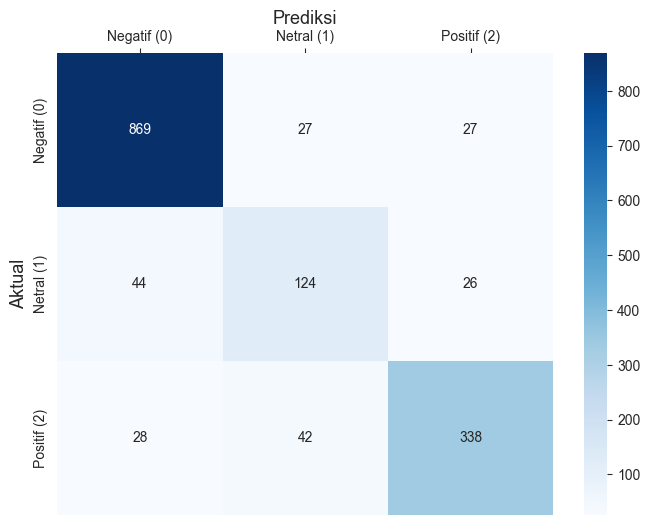

confusion matrix saved


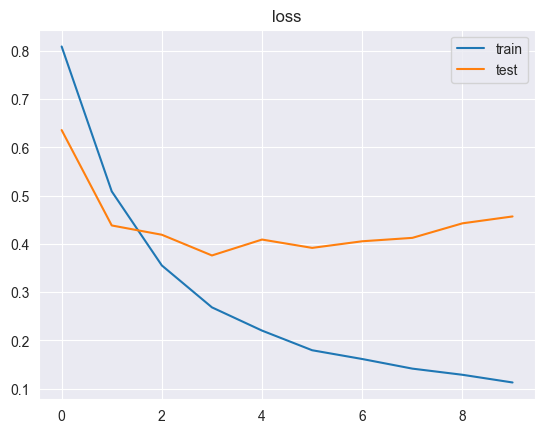

Loss and Accuracy saved at LSTM/0.2-10-32


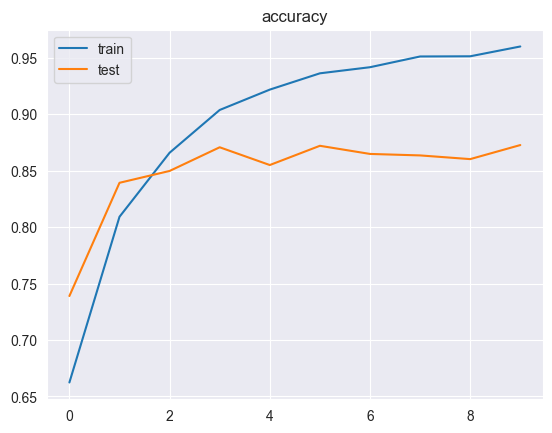

Loss and Accuracy saved at LSTM/0.2-10-32
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_55 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

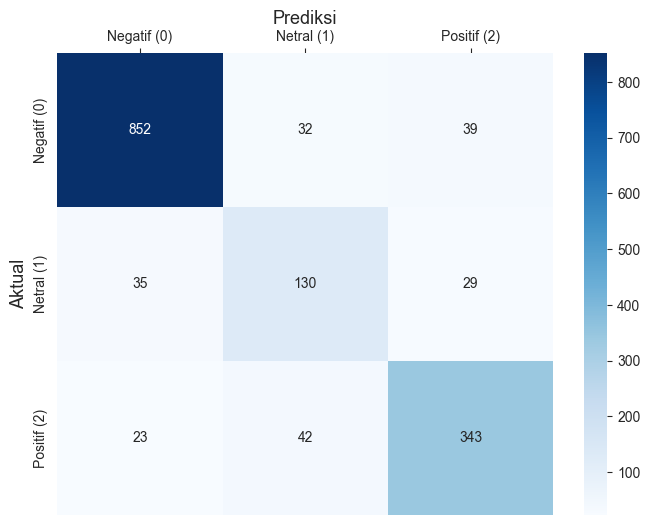

confusion matrix saved


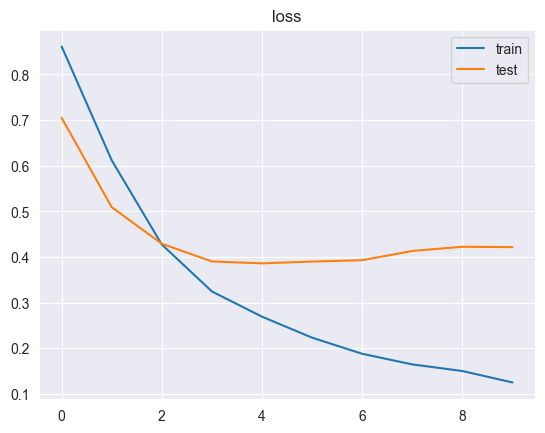

Loss and Accuracy saved at LSTM/0.2-10-64


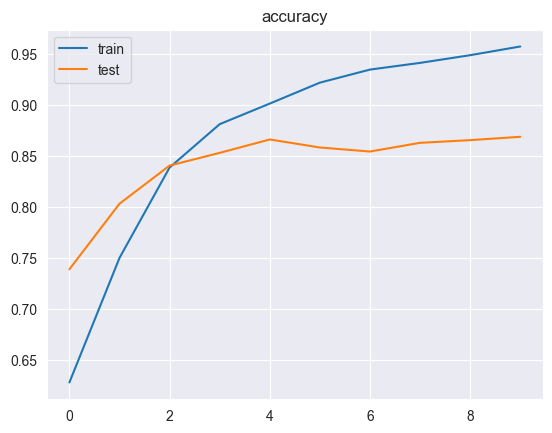

Loss and Accuracy saved at LSTM/0.2-10-64
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_57 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

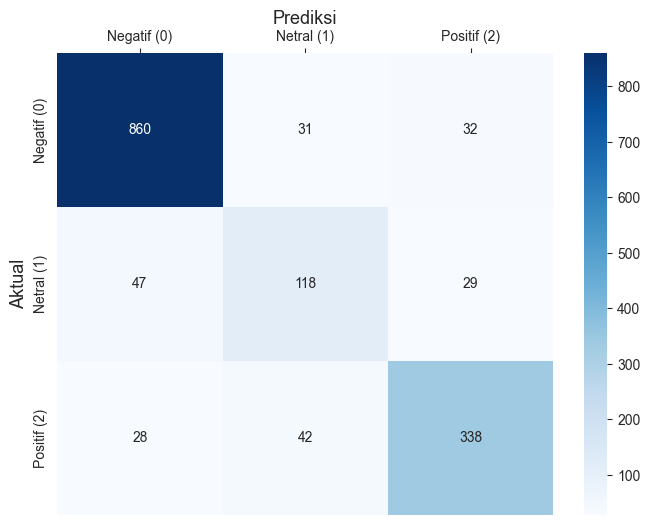

confusion matrix saved


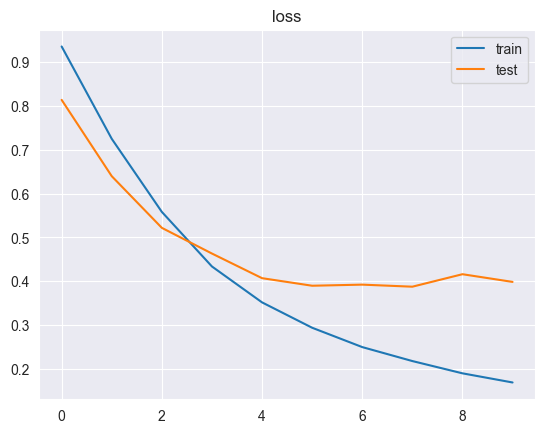

Loss and Accuracy saved at LSTM/0.2-10-128


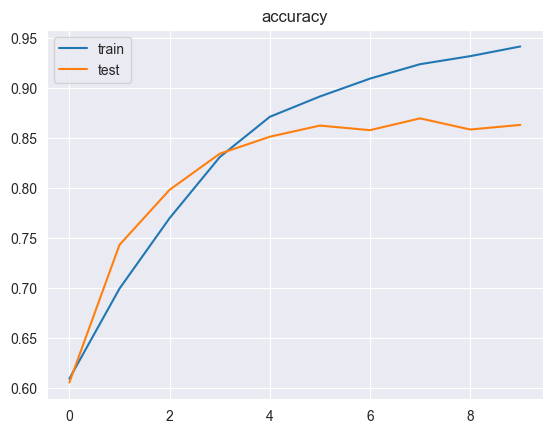

Loss and Accuracy saved at LSTM/0.2-10-128
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_59 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_60 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoc

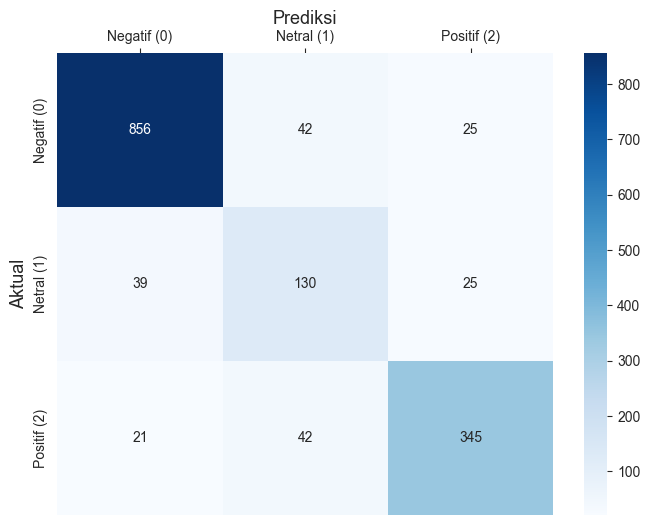

confusion matrix saved


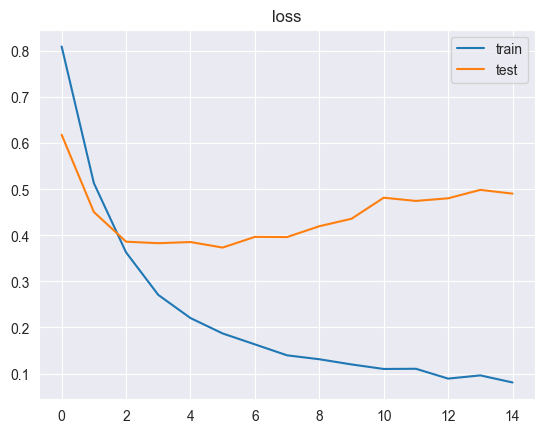

Loss and Accuracy saved at LSTM/0.2-15-32


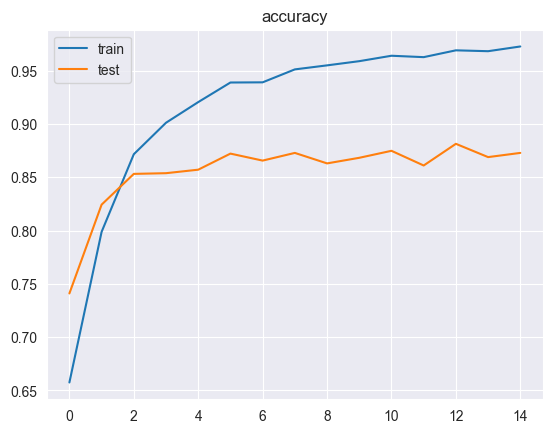

Loss and Accuracy saved at LSTM/0.2-15-32
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_61 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

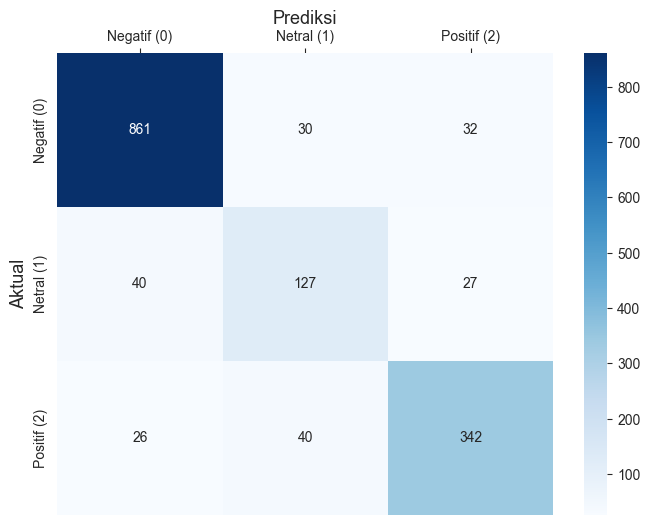

confusion matrix saved


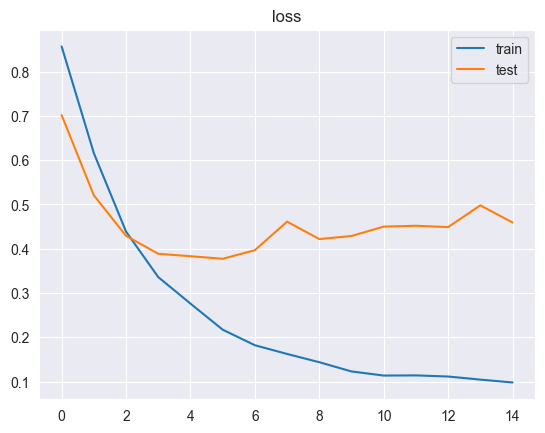

Loss and Accuracy saved at LSTM/0.2-15-64


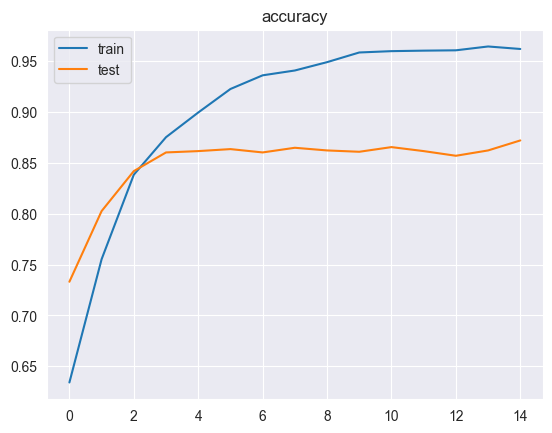

Loss and Accuracy saved at LSTM/0.2-15-64
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_63 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

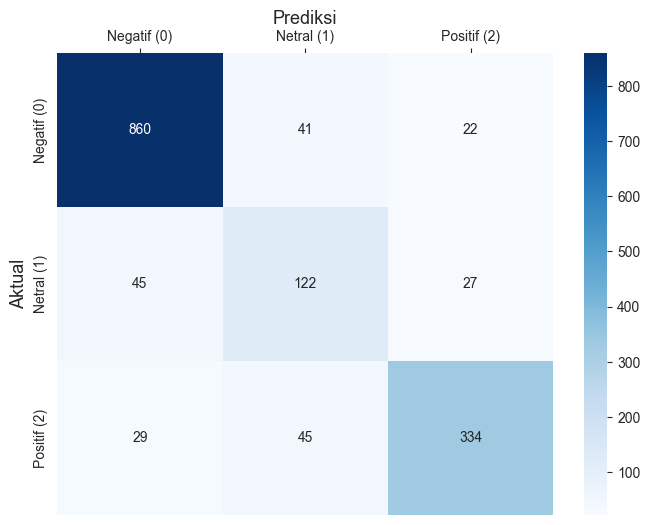

confusion matrix saved


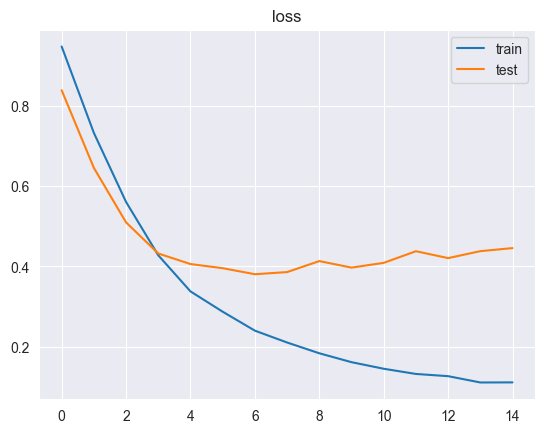

Loss and Accuracy saved at LSTM/0.2-15-128


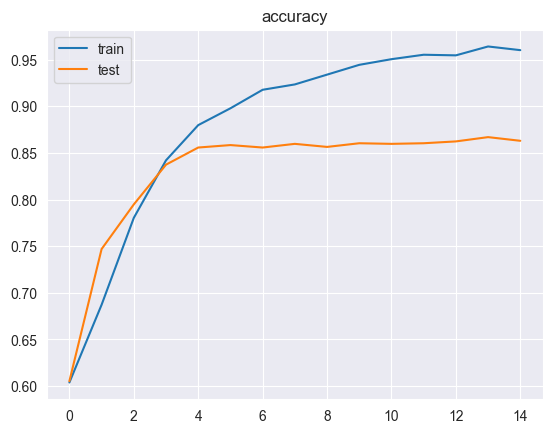

Loss and Accuracy saved at LSTM/0.2-15-128
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_65 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_66 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoc

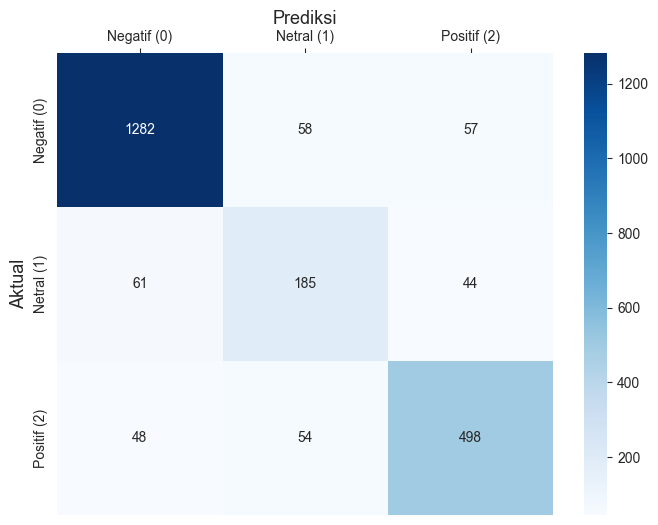

confusion matrix saved


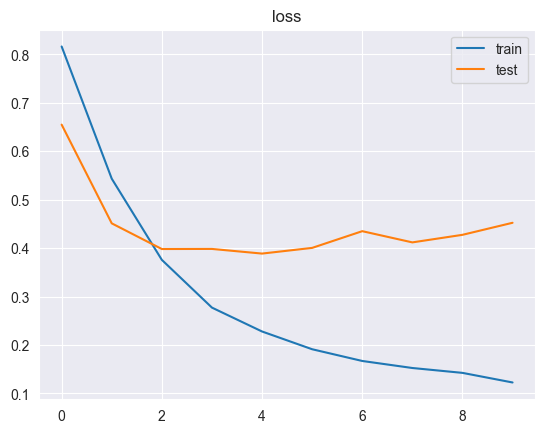

Loss and Accuracy saved at LSTM/0.3-10-32


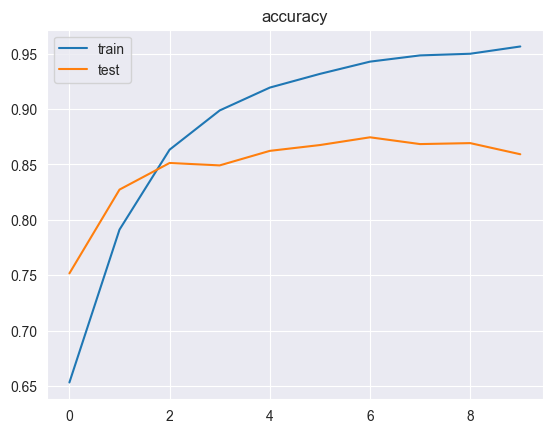

Loss and Accuracy saved at LSTM/0.3-10-32
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_67 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

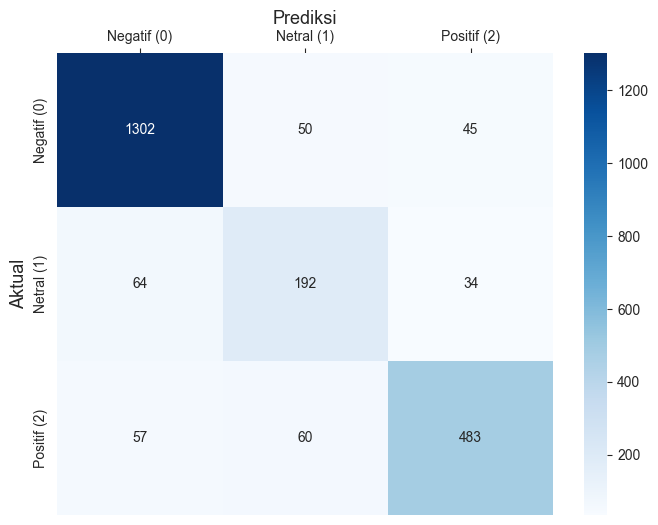

confusion matrix saved


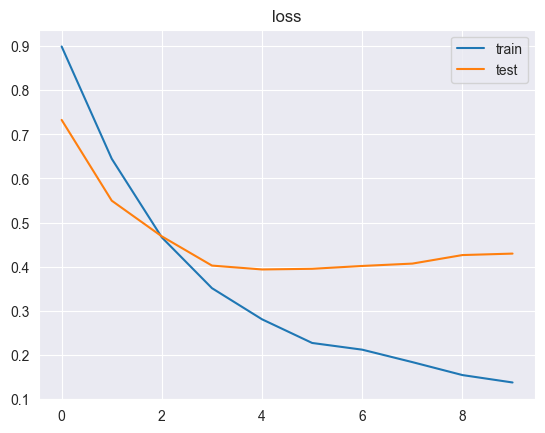

Loss and Accuracy saved at LSTM/0.3-10-64


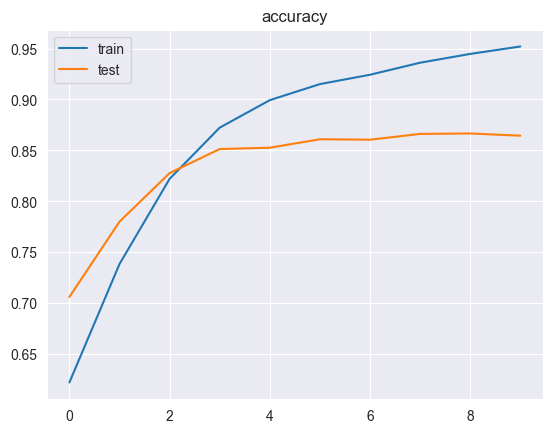

Loss and Accuracy saved at LSTM/0.3-10-64
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_69 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_70 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

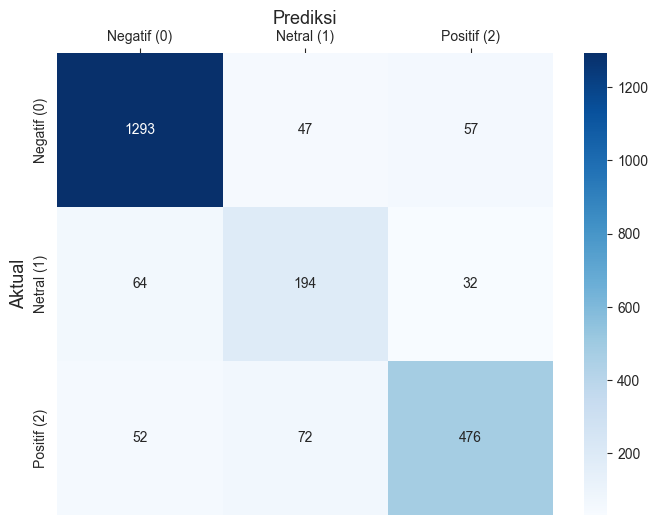

confusion matrix saved


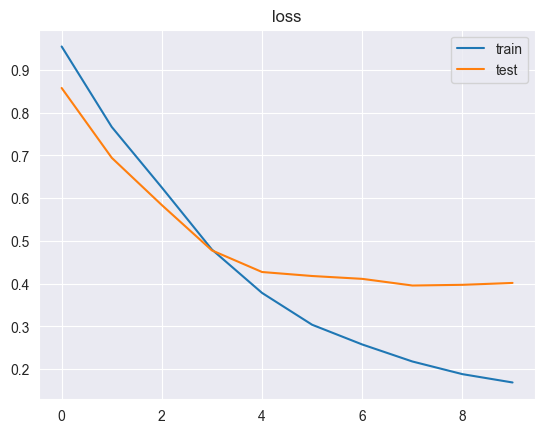

Loss and Accuracy saved at LSTM/0.3-10-128


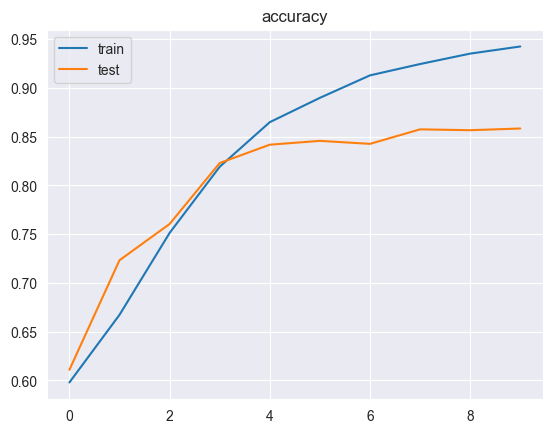

Loss and Accuracy saved at LSTM/0.3-10-128
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_71 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoc

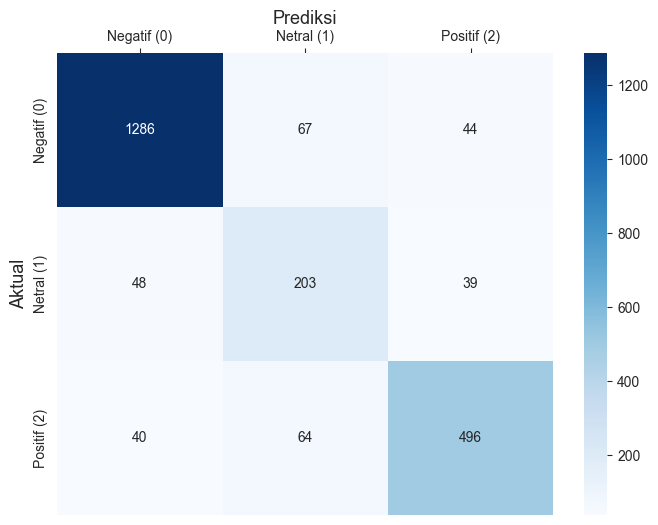

confusion matrix saved


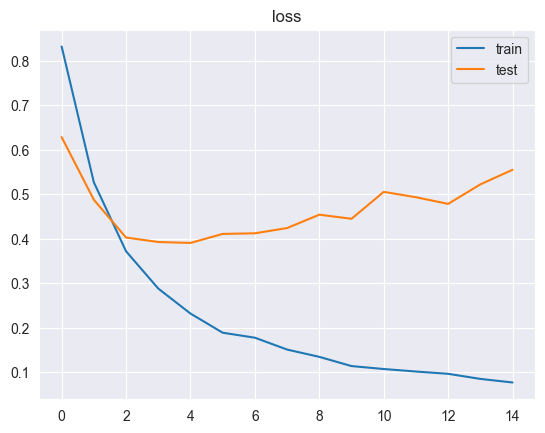

Loss and Accuracy saved at LSTM/0.3-15-32


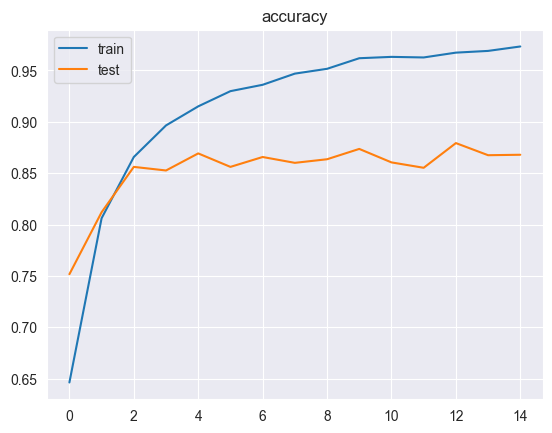

Loss and Accuracy saved at LSTM/0.3-15-32
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_73 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_74 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

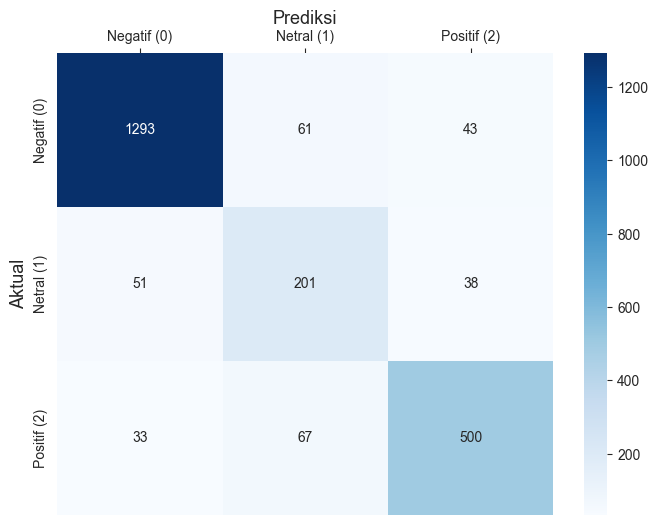

confusion matrix saved


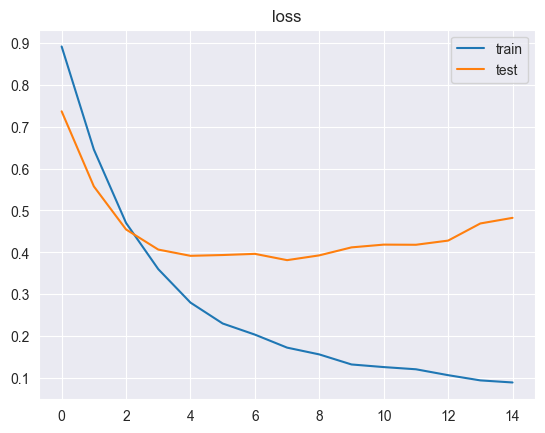

Loss and Accuracy saved at LSTM/0.3-15-64


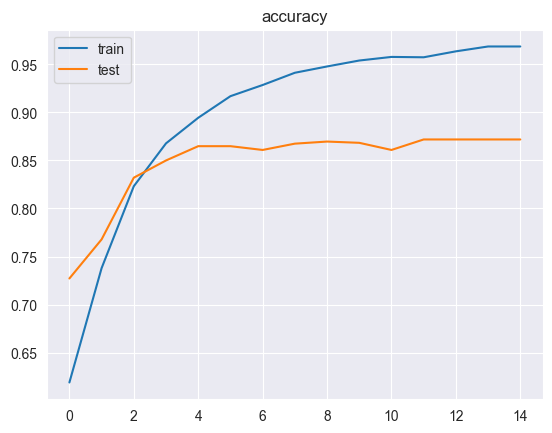

Loss and Accuracy saved at LSTM/0.3-15-64
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_75 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

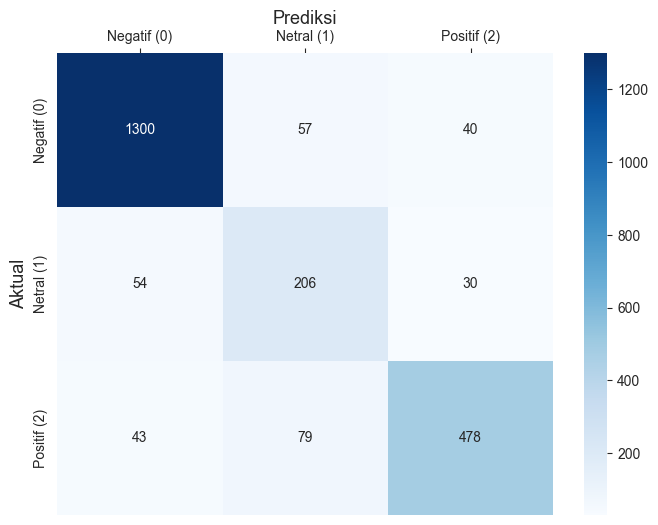

confusion matrix saved


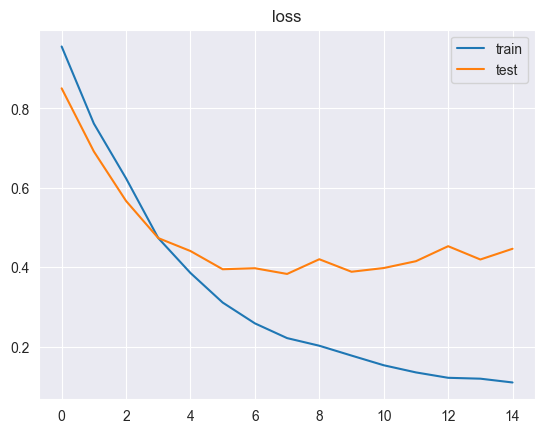

Loss and Accuracy saved at LSTM/0.3-15-128


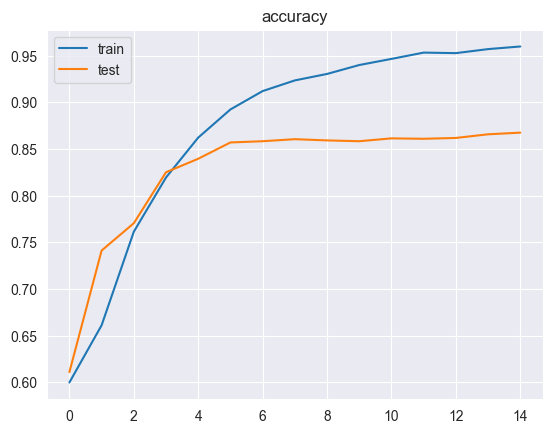

Loss and Accuracy saved at LSTM/0.3-15-128
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_77 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_78 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoc

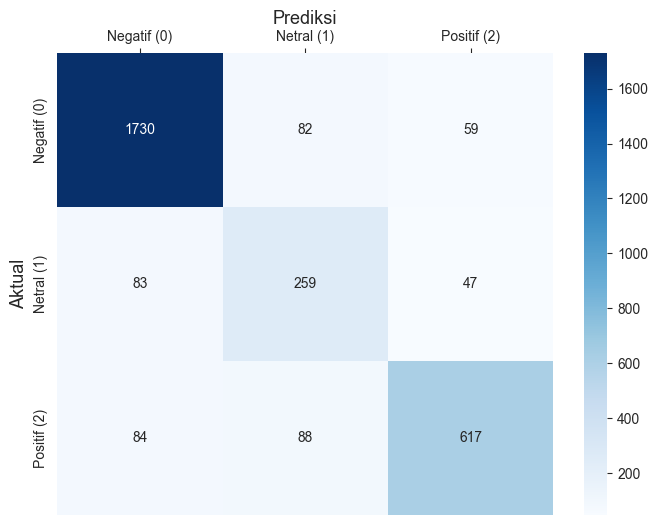

confusion matrix saved


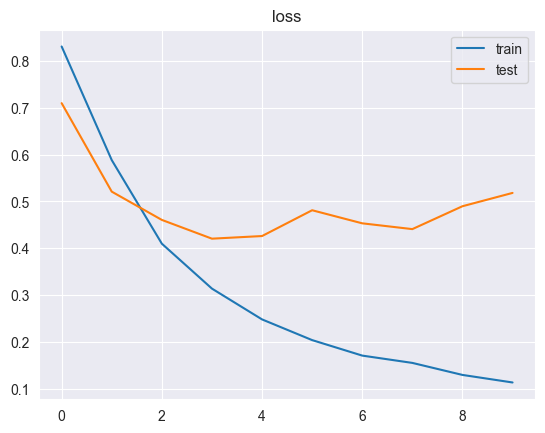

Loss and Accuracy saved at LSTM/0.4-10-32


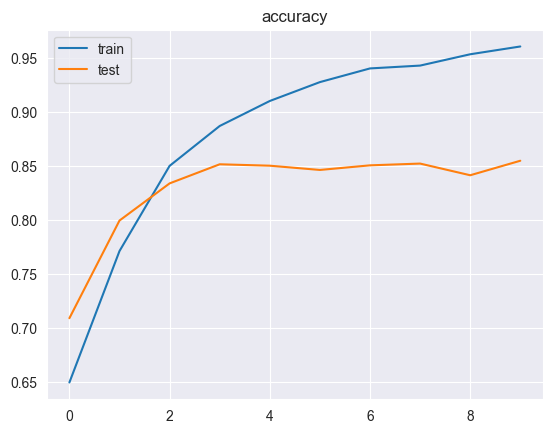

Loss and Accuracy saved at LSTM/0.4-10-32
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_79 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_80 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

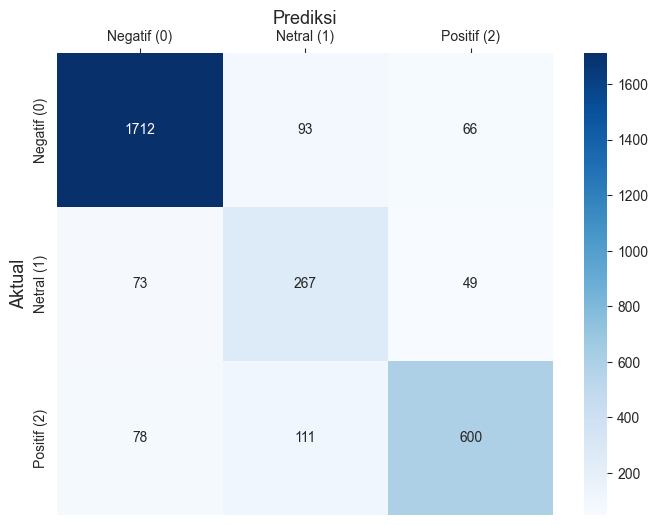

confusion matrix saved


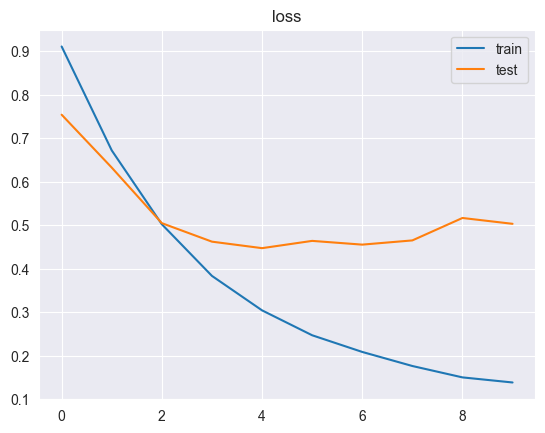

Loss and Accuracy saved at LSTM/0.4-10-64


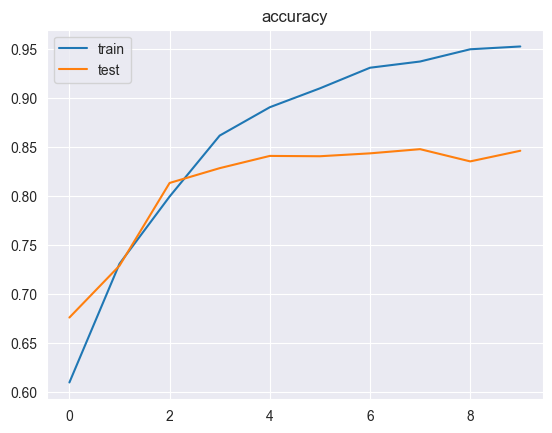

Loss and Accuracy saved at LSTM/0.4-10-64
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_81 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

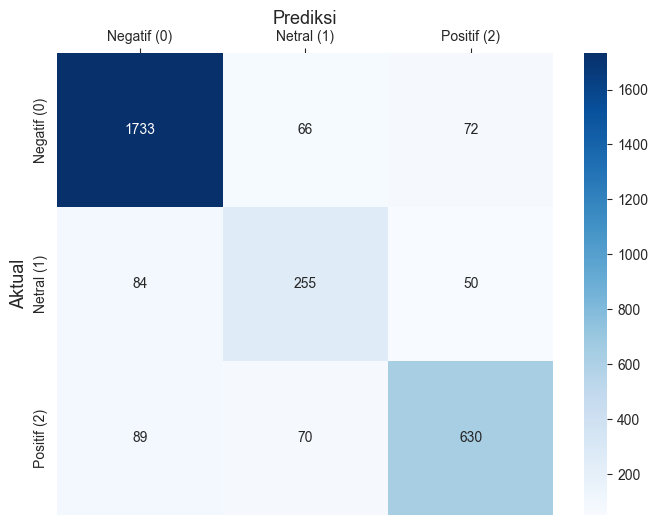

confusion matrix saved


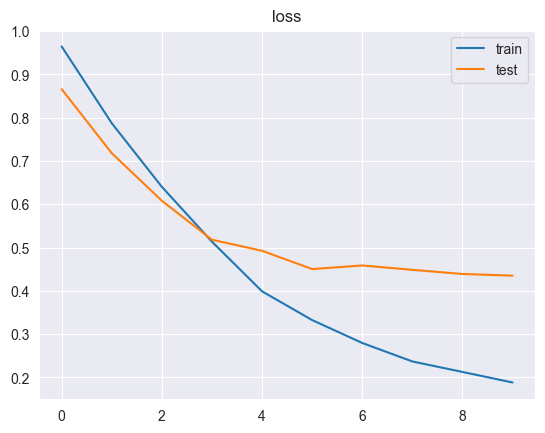

Loss and Accuracy saved at LSTM/0.4-10-128


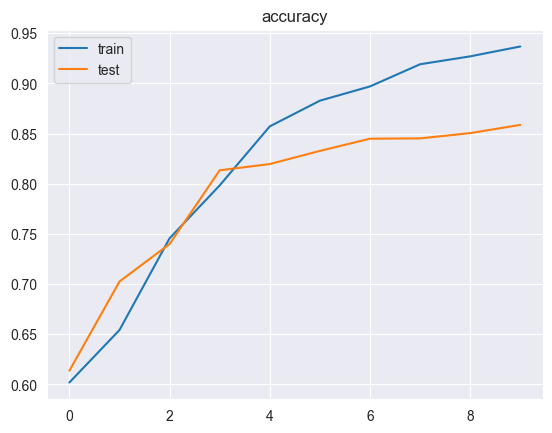

Loss and Accuracy saved at LSTM/0.4-10-128
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_83 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_84 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoc

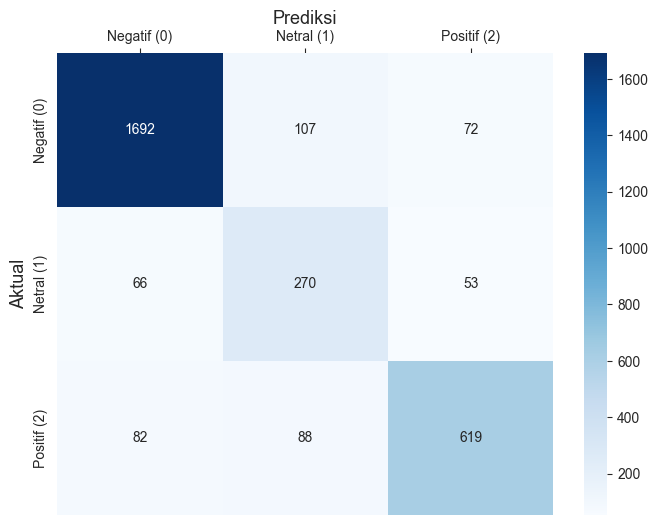

confusion matrix saved


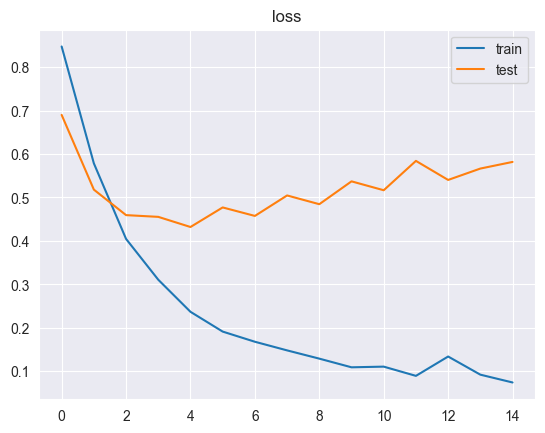

Loss and Accuracy saved at LSTM/0.4-15-32


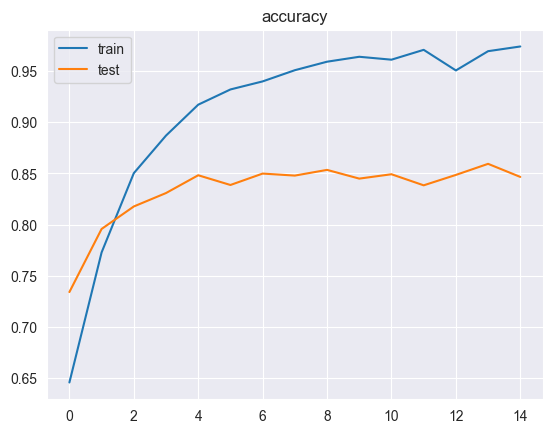

Loss and Accuracy saved at LSTM/0.4-15-32
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_85 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_86 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

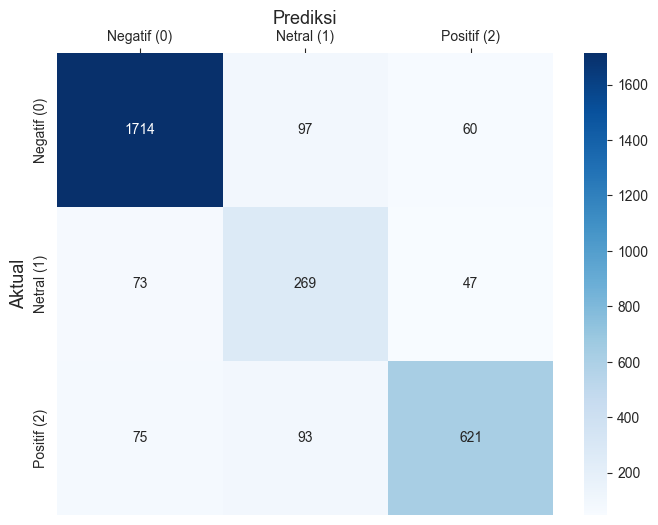

confusion matrix saved


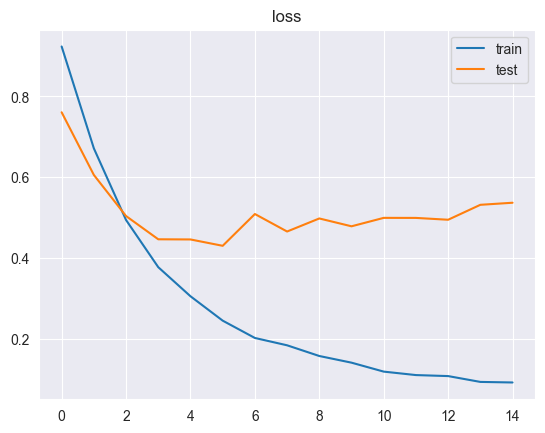

Loss and Accuracy saved at LSTM/0.4-15-64


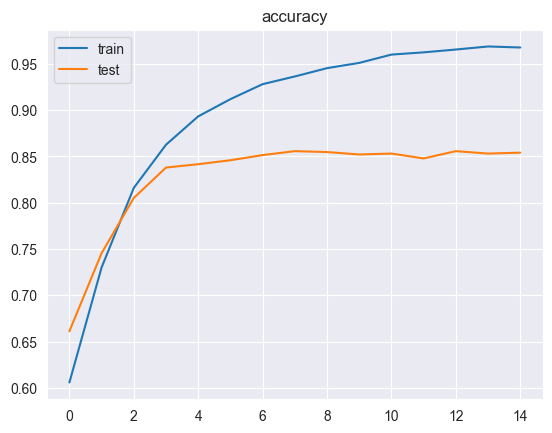

Loss and Accuracy saved at LSTM/0.4-15-64
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_87 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_88 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
Epoch

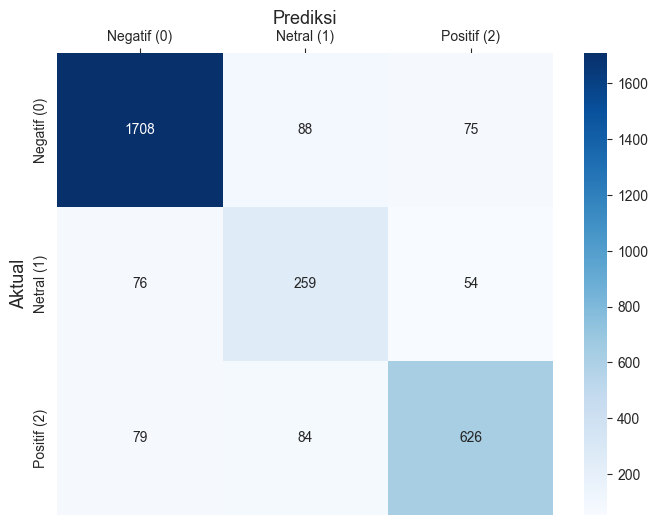

confusion matrix saved


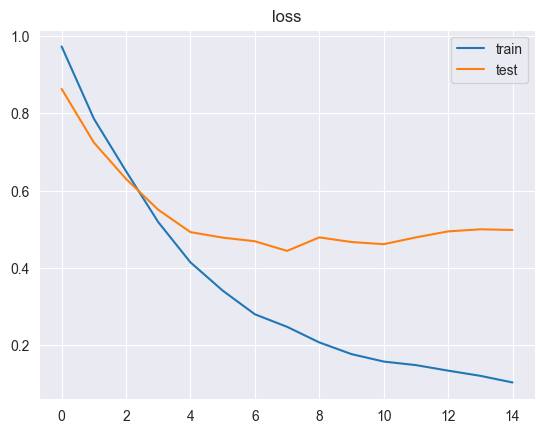

Loss and Accuracy saved at LSTM/0.4-15-128


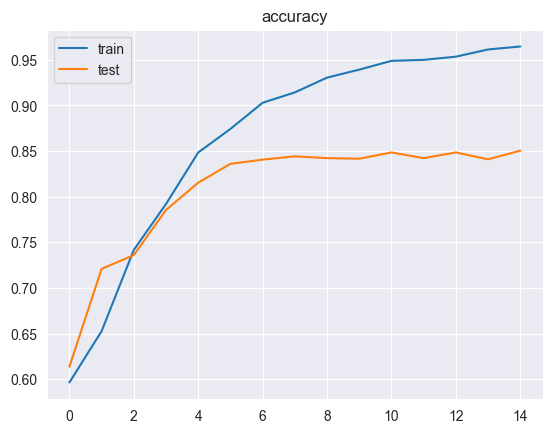

Loss and Accuracy saved at LSTM/0.4-15-128


In [39]:
train_ratio = [0.2,0.3,0.4]
batch_list = [32,64,128]
epochs_list = [10,15]
result_bucket = []
model_type = "LSTM"
for tl in train_ratio:
    for el in epochs_list:
        for bl in batch_list:
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tl, random_state = 0)
            models = model_initatiator(model_type)
            history = models.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=el, batch_size=bl, verbose=1)
            scores = models.evaluate(X_test, y_test, verbose=False)
            print(f"Accuracy: {scores[1]*100} %")
            y_pred = models.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
            acc = accuracy_score(y_test, y_pred)
            reports = classification_report(y_test,y_pred, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)'], output_dict=True)
            path_to_save = f"{model_type}/{tl}-{el}-{bl}"
            os.makedirs(path_to_save, exist_ok=True)
            path_to_save_model = f"{path_to_save}/model.h5"
            models.save(path_to_save_model)
            print(conf_matrix(y_test,y_pred))
            print(plot(history, "loss"))
            print(plot(history, "accuracy"))
            to_save = f"{path_to_save}/classification_reports.csv"
            clsf_report = pd.DataFrame(reports).transpose()
            clsf_report.to_csv(to_save,sep=';')
            results = {
                'model': model_type,
                "batch_size": bl,
                "epoch": el,
                "train_ratio": tl,
                'accuracy_score': acc
            }
            result_bucket.append(results)

df_result = pd.DataFrame(result_bucket)
df_result.to_csv(path_or_buf=f'{model_type} reports.csv', sep=';')



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 53, 64)            320000    
                                                                 
 dropout_6 (Dropout)         (None, 53, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 345,155
Trainable params: 345,155
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [============================

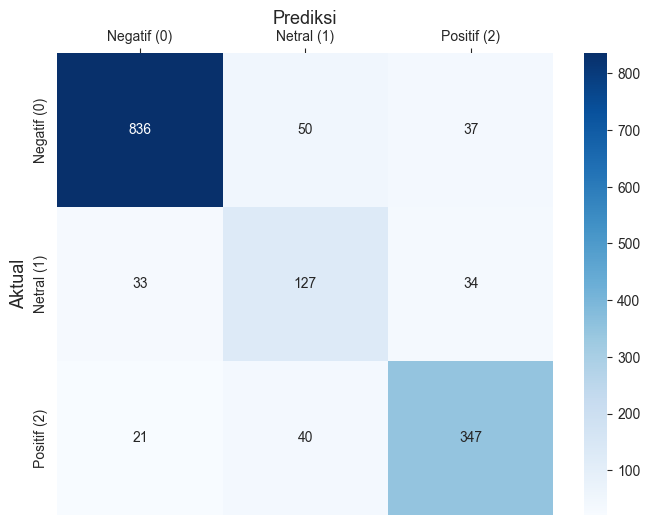

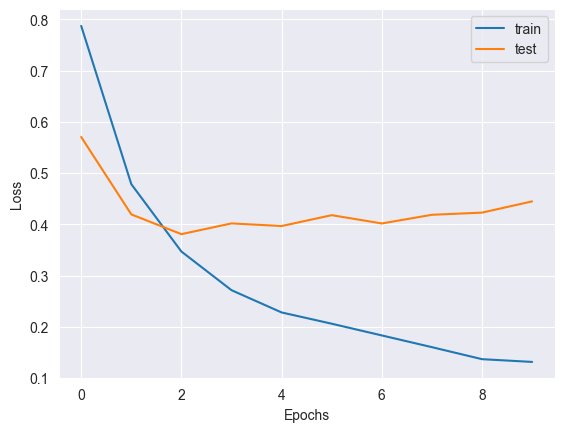

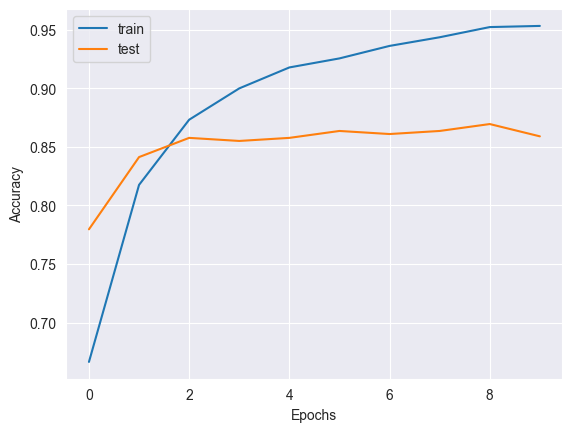

In [36]:
train_ratio = [0.2,0.3,0.4]
batch_list = [32,64,128]
epochs_list = [10,15]
result_bucket = []
for tr in train_ratio:
    for el in epochs_list:
        for bl in batch_list:
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=tr, random_state = 0)
            model_lstm = Sequential()
            model_lstm.add(Embedding(input_dim=max_feature,output_dim=64, input_length=X.shape[1]))
            model_lstm.add(Dropout(0.5))
            model_lstm.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
            model_lstm.add(Dropout(0.5))
            model_lstm.add(Dense(units=3, activation="softmax"))
            model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            model_lstm.summary()
            history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=el, batch_size=bl, verbose=1)
            scores = model_lstm.evaluate(X_test, y_test, verbose=False)
            print(f"Accuracy: {scores[1]*100} %")
            y_pred = model_lstm.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
            acc = accuracy_score(y_test, y_pred)
            reports = classification_report(y_test,y_pred, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)'], output_dict=True)
            # confusion_matrix(y_test, y_pred)
            fig, ax = plt.subplots(figsize = (8,6))
            sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, cmap='Blues')
            ax.xaxis.set_label_position('top')
            ax.xaxis.set_ticks_position('top')
            ax.set_xlabel('Prediksi', fontsize=13)
            ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
            ax.set_ylabel('Aktual', fontsize=13)
            ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
            path_to_save = f"GRU-{tr}-{el}-{bl}"
            os.makedirs(path_to_save, exist_ok=True)
            to_save = f"{path_to_save}/CF.png"
            plt.savefig(fname=to_save, format='png')
            plt.show()
            plt.close()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.plot(history.history['loss'], label = 'train')
            plt.plot(history.history['val_loss'], label = 'test')
            plt.legend()
            to_save = f"{path_to_save}/loss.png"
            plt.savefig(to_save)
            plt.show()
            plt.close()
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.plot(history.history['accuracy'], label='train')
            plt.plot(history.history['val_accuracy'], label='test')
            plt.legend()
            to_save = f"{path_to_save}/acc.png"
            plt.savefig(to_save)
            plt.show()
            plt.close()
            to_save = f"{path_to_save}/classification_reports.csv"
            clsf_report = pd.DataFrame(reports).transpose()
            clsf_report.to_csv(to_save,sep=';')
            results = {
                'model': "GRU",
                "batch_size": bl,
                "epoch": el,
                "train_ratio": tr,
                'accuracy_score': acc
            }
            result_bucket.append(results)
            break
        break
    break
df_result = pd.DataFrame(result_bucket)
df_result.to_csv('GRU reports.csv', sep=';')
